# Facial Expression Recognition (FER)

This project is the Capstone project for the ML-bookcamp (with Alexey Grigorev).

The dataset come from an old Kaggle competition:
- Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The tried CCN architectures come from variours sources (either papers or githibs):

- CNN architecture 1: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras
- CNN architecture 2: https://github.com/gitshanks/fer2013
- CNN architecture 3: https://github.com/amirhossein-hkh/facial-expression-recognition

**Note**: I used these architectures and obviously read some parts of these resources, but I tried to work by myself as much as possible.

Also, I asked Alexey about "Cheating and plagiarism" regarding the CNN architectures from these source here:
- https://datatalks-club.slack.com/archives/C0288NJ5XSA/p1638880791240000


---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import tensorflow as tf
from tensorflow import keras

In [2]:
input_path = 'data/'
output_path = 'models/'

### Execute if on Kaggle notebook

### Execute if on Google colab notebook

#### Seed for reproductibility

Does't seem very useful

# 1. Load & explore data <a class="anchor" id="P01"></a>

In [3]:
data = pd.read_csv(input_path+'fer2013.csv')

In [4]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Rename the columns <a class="anchor" id="P0_rename_columns"></a>

In [5]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

> This is not very useful in this project, but it's a good habit...

### Pandas_profiling

To quickly get a feel for the distribution of data, we can use [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling).


Note that the output is long and scrollable, so be sure to scroll through.


### Check the columns names & types <a class="anchor" id="P0_check_types"></a>

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


> The `target` values are int64
>
> **/!\** The `input` feature is an object and hence it needs to be converted / processed

### Check the ranges of values <a class="anchor" id="P0_check_range"></a>

In [8]:
data.describe() # I usually use includes='all' but its very slow with the pixels arrays

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


### Check the missing values <a class="anchor" id="P0_missing_values"></a>

In [9]:
data.isnull().sum()

emotion    0
pixels     0
usage      0
dtype: int64

> There is no missing values, so we don't need to drop or infer rows

### Check the `usage` feature repartition <a class="anchor" id="P0_check_usage"></a>

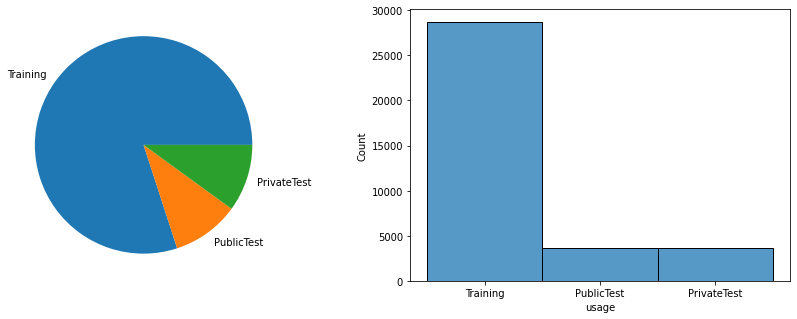

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

In [10]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['usage'].value_counts()
plt.pie(list(check), labels=check.keys())

plt.subplot(1,2,2)
sns.histplot(data['usage'])

plt.show()
check

In [11]:
total_size = data['usage'].count()
for i, v in enumerate(data['usage'].unique()):
    set_size = data['usage'].value_counts()[i]
    percent = set_size/(total_size/100.0)
    print(f"{v} has {percent:0.2F}% of the total inputs ({set_size}/{total_size})")

Training has 80.00% of the total inputs (28709/35887)
PublicTest has 10.00% of the total inputs (3589/35887)
PrivateTest has 10.00% of the total inputs (3589/35887)


#### First solution:
> The `Training` part can be used as `Training set`
>
> The `PublicTest` part can be used as `Validation set`
>
> The `PrivateTest` part can be used as `Test set`
#### Second solution:
> The 3 sets are merged and then splitted using the sklearn train_test_split function.

### Check the `emotion` target variable <a class="anchor" id="P0_target_variable"></a>

In [12]:
emotion_names = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral',
}

In [13]:
data['emotion'].describe()

count    35887.000000
mean         3.323265
std          1.873819
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: emotion, dtype: float64

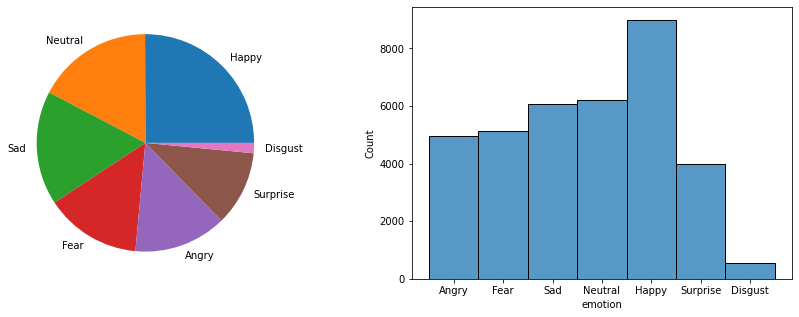

(3) Happy    => 8989
(6) Neutral  => 6198
(4) Sad      => 6077
(2) Fear     => 5121
(0) Angry    => 4953
(5) Surprise => 4002
(1) Disgust  =>  547


In [14]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['emotion'].value_counts()
plt.pie(list(check), labels=check.keys().map(emotion_names))

plt.subplot(1,2,2)
sns.histplot(data['emotion'].map(emotion_names))

plt.show()

for i, n, v in zip(check.keys(),check.keys().map(emotion_names), check.values):
    print(f"({i}) {n:8} => {v:4}")

> The `Disgust` value seem under-represented. The dataset is clearly imbalanced.
>
> So we will need to use an appropriate solution *(use upsampling and downsampling techniques)* or metric.<br>
> However there is no longtail to consider as the values are restricted to 10
>
> **/!\ Should we remove this expression** in order to improve the result on the other expressions?

In [15]:
data = data[data['emotion'] != 1]

In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [17]:
le = LabelEncoder()
img_labels = le.fit_transform(data['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35340, 6)

### Check the `pixels` input feature <a class="anchor" id="P0_input_feature"></a>

This feature is fullfiled with strings containing grayscale integers.

#### Convert `pixels` input `strings` to `arrays`
/!\ The process takes a lot of ressources, it may slow down your computer.

In [18]:
img_array = data['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

#### Display some images

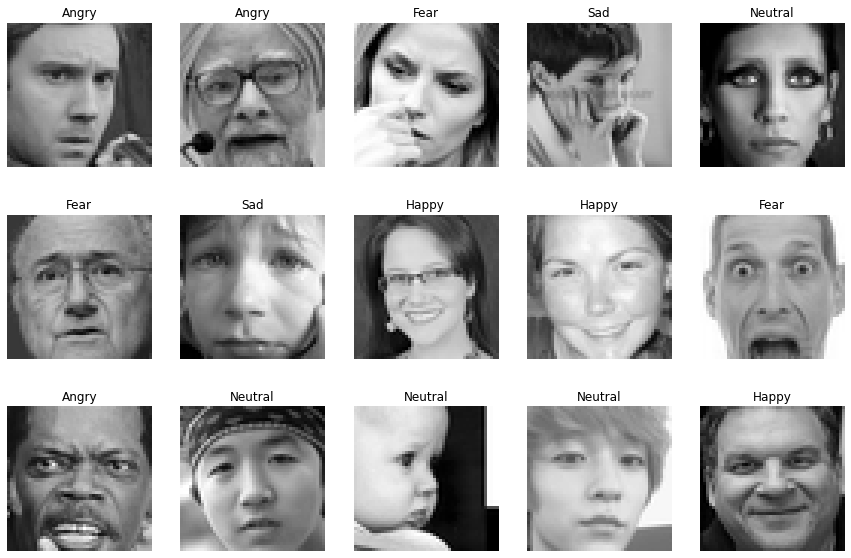

In [19]:
fig = plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(img_array[i], cmap='gray', vmin=0, vmax=255)
    plt.title(emotion_names[data['emotion'][i]])
    plt.axis('off')
    
plt.show()

# 2. Feature selection <a class="anchor" id="P02"></a>

> On this project, we don't really feature selection...
>
> There is only two input features, `pixels` and `usage`.
> - The `usage` column will be used to split the dataset, then it will be removed.
> - The `pixels` column will be used to train the CNN

# 3. Split the dataset <a class="anchor" id="P03"></a>

As seen above, the `usage` column can be used to split the dataset instead of using the train_test_split function from sklearn.

In [20]:
from sklearn.model_selection import train_test_split

In [91]:
num_samples = 15000

In [92]:
X_train_full, X_test, y_train_full, y_test = train_test_split(img_array[:num_samples], img_labels[:num_samples], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=42)

In [93]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((9000, 48, 48, 1), (3000, 48, 48, 1), (9000, 6), (3000, 6))

In [94]:
assert(X_valid.shape[0] == X_test.shape[0])

In [95]:
assert(img_array[:num_samples].shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

In [96]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

img_width, img_height, img_depth, num_classes

(48, 48, 1, 6)

# 4. Prepare generators

In [97]:
from keras.preprocessing.image import ImageDataGenerator

#### Define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [98]:
train_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
train_datagen

In [99]:
valid_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
valid_datagen

#### Define an instance of the ImageDataGenerator that with way more transformations

In [100]:
train_datagen_extra = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
train_datagen_extra

In [101]:
valid_datagen_extra = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
valid_datagen_extra

#### Initialize the train & valid generators from the numpy arrays

In [102]:
gen_batch_size=32

In [103]:
train_ds = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [104]:
valid_ds = valid_datagen.flow( ## train_datagen ?
    x=X_valid,
    y=y_valid,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [105]:
train_ds_extra = train_datagen_extra.flow(
    x=X_train,
    y=y_train,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [106]:
valid_ds_extra = valid_datagen_extra.flow( ## train_datagen ?
    x=X_valid,
    y=y_valid,
    batch_size=gen_batch_size,
    shuffle=True,
)

# 5. Try various *classification* models <a class="anchor" id="P04"></a>

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

## Convolutional Neural Network - Architecture 1

CNN architecture from: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras

In [108]:
def architecture1():
    inputs = keras.Input(shape=(img_width, img_height, img_depth))
    
    # 1st convolution
    C = Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
    B = BatchNormalization()(C)
    A = Activation('relu')(B)
    M = MaxPooling2D((2,2))(A)
    D = Dropout(0.25)(M)
    
    # 2nd convolution
    Con = Conv2D(filters=128, kernel_size=(5,5), padding='same')(D)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # 3rd convolution
    Con = Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # 4rd convolution
    Con = Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # Flatten layer
    Fla = Flatten()(Dro)
    
    # 1st fully connected layer
    Den = Dense(256)(Fla)
    Bat = BatchNormalization()(Den)
    Act = Activation('relu')(Bat)
    Dro = Dropout(0.25)(Act)
    
    # 2nd fully connected layer
    Den = Dense(512)(Dro)
    Bat = BatchNormalization()(Den)
    Act = Activation('relu')(Bat)
    Dro = Dropout(0.25)(Act)
    
    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    outputs = Dense(num_classes, activation='softmax')(Dro)
    
    model = keras.Model(inputs, outputs)
    return model
    

In [109]:
architecture1().summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_80 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_68 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 24, 24, 64)        0   

## Convolutional Neural Network - Architecture 2

CNN architecture from: https://github.com/gitshanks/fer2013

In [110]:
from keras.regularizers import l2

def architecture2():

    num_features = 64
    #batch_size = 64

    model = Sequential()
    
    # 1st convolution
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, img_depth), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 2nd convolution
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 3rd convolution
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 4rd convolution
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # 1st fully connected layer    
    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    model.add(Dense(num_classes, activation='softmax'))
    return model
    

In [111]:
architecture2().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_65 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_86 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_78 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 23, 23, 128)      

## Convolutional Neural Network - Architecture 3

CNN architecture from: https://github.com/amirhossein-hkh/facial-expression-recognition

In [112]:
def architecture3():
  
    model = Sequential()

    # 1st convolution
    model.add(Conv2D(64, (3, 3), input_shape=(img_width, img_height,img_depth)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd convolution
    model.add(Conv2D(128, (3, 3)))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd convolution
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4rd convolution
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten()) 

    # 1st fully connected layer
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # 2nd fully connected layer
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
  
    return model

In [113]:
architecture3().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 activation_74 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 batch_normalization_93 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 dropout_85 (Dropout)        (None, 21, 21, 128)      

## Define Optimizer & Loss


In [114]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)

In [115]:
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

## Compile the model

In [116]:
### model1.compile(optimizer=f_opti, loss=f_loss, metrics=[keras.metrics.CategoricalAccuracy()])

## Fit the models

In [117]:
from tqdm.keras import TqdmCallback

In [122]:
batch_size=64
epochs=100
steps_per_epoch=100
validation_steps=50

In [123]:
from keras.callbacks import ModelCheckpoint

In [124]:
def fit_and_save(model, train_ds, valid_ds, name="model"):
    
    filepath = output_path+name+'.epoch{epoch:02d}-categorical_accuracy{val_categorical_accuracy:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             #monitor='val_loss',
                             #mode='min'
                             #monitor='val_auc',
                             monitor='val_categorical_accuracy',
                             mode='max',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             )
    # Compile model
    model.compile(optimizer=f_opti, loss=f_loss, metrics=[keras.metrics.CategoricalAccuracy()])

    # Save model
    model.save(output_path+name+".h5")

    # Fit model
    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        validation_steps=validation_steps,
        callbacks=[TqdmCallback(), checkpoint],
        verbose=1,
    )

    # Save weights
    model_json = model.to_json()
    with open(output_path+name+".json", "w") as yaml_file:
        yaml_file.write(model_json)

    return history

In [125]:
model1 = architecture1()
history1 = fit_and_save(model1, train_ds, valid_ds, name="model1")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.9738 - categorical_accuracy: 0.2350
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16688, saving model to models/model1.epoch01-categorical_accuracy0.17.hdf5
100/100 [==============================] - 60s 591ms/step - loss: 1.9738 - categorical_accuracy: 0.2350 - val_loss: 1.8168 - val_categorical_accuracy: 0.1669
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.8816 - categorical_accuracy: 0.2494
Epoch 00002: val_categorical_accuracy did not improve from 0.16688
100/100 [==============================] - 67s 671ms/step - loss: 1.8816 - categorical_accuracy: 0.2494 - val_loss: 1.9952 - val_categorical_accuracy: 0.1575
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.8303 - categorical_accuracy: 0.2713
Epoch 00003: val_categorical_accuracy improved from 0.16688 to 0.25875, saving model to models/model1.epoch03-categorical_accuracy0.26.hdf5
100/100 [====

100/100 [==============================] - ETA: 0s - loss: 1.0812 - categorical_accuracy: 0.5928
Epoch 00023: val_categorical_accuracy did not improve from 0.52375
100/100 [==============================] - 72s 725ms/step - loss: 1.0812 - categorical_accuracy: 0.5928 - val_loss: 1.3059 - val_categorical_accuracy: 0.5156
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 1.0357 - categorical_accuracy: 0.6041
Epoch 00024: val_categorical_accuracy did not improve from 0.52375
100/100 [==============================] - 74s 740ms/step - loss: 1.0357 - categorical_accuracy: 0.6041 - val_loss: 1.2852 - val_categorical_accuracy: 0.5138
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 1.0360 - categorical_accuracy: 0.6050
Epoch 00025: val_categorical_accuracy improved from 0.52375 to 0.52875, saving model to models/model1.epoch25-categorical_accuracy0.53.hdf5
100/100 [==============================] - 73s 726ms/step - loss: 1.0360 - categorical_accura

Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.6587 - categorical_accuracy: 0.7509
Epoch 00047: val_categorical_accuracy did not improve from 0.55125
100/100 [==============================] - 78s 778ms/step - loss: 0.6587 - categorical_accuracy: 0.7509 - val_loss: 1.2724 - val_categorical_accuracy: 0.5475
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.6574 - categorical_accuracy: 0.7554
Epoch 00048: val_categorical_accuracy did not improve from 0.55125
100/100 [==============================] - 75s 753ms/step - loss: 0.6574 - categorical_accuracy: 0.7554 - val_loss: 1.3532 - val_categorical_accuracy: 0.5300
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.6426 - categorical_accuracy: 0.7541
Epoch 00049: val_categorical_accuracy did not improve from 0.55125
100/100 [==============================] - 74s 739ms/step - loss: 0.6426 - categorical_accuracy: 0.7541 - val_loss: 1.4509 - val_categorical_accuracy: 0.

100/100 [==============================] - ETA: 0s - loss: 0.3545 - categorical_accuracy: 0.8668
Epoch 00071: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 68s 685ms/step - loss: 0.3545 - categorical_accuracy: 0.8668 - val_loss: 1.9694 - val_categorical_accuracy: 0.4894
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.3640 - categorical_accuracy: 0.8691
Epoch 00072: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 69s 687ms/step - loss: 0.3640 - categorical_accuracy: 0.8691 - val_loss: 1.7271 - val_categorical_accuracy: 0.5213
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.3628 - categorical_accuracy: 0.8716
Epoch 00073: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 70s 696ms/step - loss: 0.3628 - categorical_accuracy: 0.8716 - val_loss: 1.6572 - val_categorical_accuracy: 0.5550
Epoch 74

Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.2196 - categorical_accuracy: 0.9206
Epoch 00096: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 69s 687ms/step - loss: 0.2196 - categorical_accuracy: 0.9206 - val_loss: 1.8637 - val_categorical_accuracy: 0.5506
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.2294 - categorical_accuracy: 0.9200
Epoch 00097: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 68s 684ms/step - loss: 0.2294 - categorical_accuracy: 0.9200 - val_loss: 2.0778 - val_categorical_accuracy: 0.5244
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 0.2212 - categorical_accuracy: 0.9269
Epoch 00098: val_categorical_accuracy did not improve from 0.56187
100/100 [==============================] - 68s 682ms/step - loss: 0.2212 - categorical_accuracy: 0.9269 - val_loss: 1.8151 - val_categorical_accuracy: 0.

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00064: val_categorical_accuracy improved from 0.55437 to `0.56187`, saving model to models/model1.epoch64-categorical_accuracy0.56.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00084: val_categorical_accuracy improved from 0.61313 to `0.62344`, saving model to ./model1.epoch84-categorical_accuracy0.62.hdf5*

In [126]:
model1extra = architecture1()
history1extra = fit_and_save(model1extra, train_ds_extra, valid_ds_extra, name="model1extra")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.0573 - categorical_accuracy: 0.2219
Epoch 00001: val_categorical_accuracy improved from -inf to 0.15563, saving model to models/model1extra.epoch01-categorical_accuracy0.16.hdf5
100/100 [==============================] - 70s 690ms/step - loss: 2.0573 - categorical_accuracy: 0.2219 - val_loss: 1.8537 - val_categorical_accuracy: 0.1556
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.8570 - categorical_accuracy: 0.2316
Epoch 00002: val_categorical_accuracy improved from 0.15563 to 0.25313, saving model to models/model1extra.epoch02-categorical_accuracy0.25.hdf5
100/100 [==============================] - 68s 684ms/step - loss: 1.8570 - categorical_accuracy: 0.2316 - val_loss: 1.8037 - val_categorical_accuracy: 0.2531
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.8144 - categorical_accuracy: 0.2331
Epoch 00003: val_categorical_accuracy did not improve from 0.25313
100

Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 1.3958 - categorical_accuracy: 0.4559
Epoch 00024: val_categorical_accuracy improved from 0.40875 to 0.45562, saving model to models/model1extra.epoch24-categorical_accuracy0.46.hdf5
100/100 [==============================] - 67s 669ms/step - loss: 1.3958 - categorical_accuracy: 0.4559 - val_loss: 1.3967 - val_categorical_accuracy: 0.4556
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 1.3980 - categorical_accuracy: 0.4416
Epoch 00025: val_categorical_accuracy did not improve from 0.45562
100/100 [==============================] - 68s 677ms/step - loss: 1.3980 - categorical_accuracy: 0.4416 - val_loss: 1.4151 - val_categorical_accuracy: 0.4281
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 1.3664 - categorical_accuracy: 0.4575
Epoch 00026: val_categorical_accuracy improved from 0.45562 to 0.47375, saving model to models/model1extra.epoch26-categorical_accuracy0.47.hd

100/100 [==============================] - ETA: 0s - loss: 1.2192 - categorical_accuracy: 0.5194
Epoch 00047: val_categorical_accuracy did not improve from 0.51313
100/100 [==============================] - 68s 679ms/step - loss: 1.2192 - categorical_accuracy: 0.5194 - val_loss: 1.2693 - val_categorical_accuracy: 0.5106
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 1.2281 - categorical_accuracy: 0.5141
Epoch 00048: val_categorical_accuracy did not improve from 0.51313
100/100 [==============================] - 68s 681ms/step - loss: 1.2281 - categorical_accuracy: 0.5141 - val_loss: 1.3269 - val_categorical_accuracy: 0.4869
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 1.1892 - categorical_accuracy: 0.5300
Epoch 00049: val_categorical_accuracy did not improve from 0.51313
100/100 [==============================] - 67s 675ms/step - loss: 1.1892 - categorical_accuracy: 0.5300 - val_loss: 1.5142 - val_categorical_accuracy: 0.3856
Epoch 50

100/100 [==============================] - ETA: 0s - loss: 1.1333 - categorical_accuracy: 0.5526
Epoch 00071: val_categorical_accuracy did not improve from 0.54438
100/100 [==============================] - 68s 680ms/step - loss: 1.1333 - categorical_accuracy: 0.5526 - val_loss: 1.3095 - val_categorical_accuracy: 0.4688
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 1.1420 - categorical_accuracy: 0.5584
Epoch 00072: val_categorical_accuracy did not improve from 0.54438
100/100 [==============================] - 68s 681ms/step - loss: 1.1420 - categorical_accuracy: 0.5584 - val_loss: 1.1945 - val_categorical_accuracy: 0.5369
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 1.1419 - categorical_accuracy: 0.5503
Epoch 00073: val_categorical_accuracy did not improve from 0.54438
100/100 [==============================] - 68s 679ms/step - loss: 1.1419 - categorical_accuracy: 0.5503 - val_loss: 1.2690 - val_categorical_accuracy: 0.4981
Epoch 74

100/100 [==============================] - ETA: 0s - loss: 1.0737 - categorical_accuracy: 0.5910
Epoch 00095: val_categorical_accuracy did not improve from 0.56500
100/100 [==============================] - 67s 675ms/step - loss: 1.0737 - categorical_accuracy: 0.5910 - val_loss: 1.2395 - val_categorical_accuracy: 0.5231
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 1.0814 - categorical_accuracy: 0.5731
Epoch 00096: val_categorical_accuracy did not improve from 0.56500
100/100 [==============================] - 68s 678ms/step - loss: 1.0814 - categorical_accuracy: 0.5731 - val_loss: 1.3083 - val_categorical_accuracy: 0.4837
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 1.0623 - categorical_accuracy: 0.5957
Epoch 00097: val_categorical_accuracy did not improve from 0.56500
100/100 [==============================] - 67s 672ms/step - loss: 1.0623 - categorical_accuracy: 0.5957 - val_loss: 1.2334 - val_categorical_accuracy: 0.5244
Epoch 98

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00079: val_categorical_accuracy improved from 0.54438 to `0.56500`, saving model to models/model1extra.epoch79-categorical_accuracy0.56.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00119: val_categorical_accuracy improved from 0.61344 to `0.61687`, saving model to ./model1extra.epoch119-categorical_accuracy0.62.hdf5*

In [127]:
model2 = architecture2()
history2 = fit_and_save(model2, train_ds, valid_ds, name="model2")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.5015 - categorical_accuracy: 0.1962
Epoch 00001: val_categorical_accuracy improved from -inf to 0.23250, saving model to models/model2.epoch01-categorical_accuracy0.23.hdf5
100/100 [==============================] - 92s 910ms/step - loss: 2.5015 - categorical_accuracy: 0.1962 - val_loss: 1.8017 - val_categorical_accuracy: 0.2325
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.8434 - categorical_accuracy: 0.2273
Epoch 00002: val_categorical_accuracy improved from 0.23250 to 0.26438, saving model to models/model2.epoch02-categorical_accuracy0.26.hdf5
100/100 [==============================] - 91s 913ms/step - loss: 1.8434 - categorical_accuracy: 0.2273 - val_loss: 1.7850 - val_categorical_accuracy: 0.2644
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.7919 - categorical_accuracy: 0.2434
Epoch 00003: val_categorical_accuracy did not improve from 0.26438
100/100 [====

100/100 [==============================] - ETA: 0s - loss: 1.7507 - categorical_accuracy: 0.2447
Epoch 00025: val_categorical_accuracy did not improve from 0.26438
100/100 [==============================] - 92s 920ms/step - loss: 1.7507 - categorical_accuracy: 0.2447 - val_loss: 1.7483 - val_categorical_accuracy: 0.2519
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 1.7523 - categorical_accuracy: 0.2456
Epoch 00026: val_categorical_accuracy did not improve from 0.26438
100/100 [==============================] - 91s 913ms/step - loss: 1.7523 - categorical_accuracy: 0.2456 - val_loss: 1.7449 - val_categorical_accuracy: 0.2625
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 1.7514 - categorical_accuracy: 0.2572
Epoch 00027: val_categorical_accuracy did not improve from 0.26438
100/100 [==============================] - 92s 917ms/step - loss: 1.7514 - categorical_accuracy: 0.2572 - val_loss: 1.7471 - val_categorical_accuracy: 0.2362
Epoch 28

Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 1.5655 - categorical_accuracy: 0.3580
Epoch 00049: val_categorical_accuracy improved from 0.33562 to 0.37938, saving model to models/model2.epoch49-categorical_accuracy0.38.hdf5
100/100 [==============================] - 91s 912ms/step - loss: 1.5655 - categorical_accuracy: 0.3580 - val_loss: 1.5375 - val_categorical_accuracy: 0.3794
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 1.5774 - categorical_accuracy: 0.3450
Epoch 00050: val_categorical_accuracy did not improve from 0.37938
100/100 [==============================] - 91s 913ms/step - loss: 1.5774 - categorical_accuracy: 0.3450 - val_loss: 1.6402 - val_categorical_accuracy: 0.2900
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 1.5240 - categorical_accuracy: 0.3722
Epoch 00051: val_categorical_accuracy improved from 0.37938 to 0.41000, saving model to models/model2.epoch51-categorical_accuracy0.41.hdf5
100/100

Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 1.3528 - categorical_accuracy: 0.4421
Epoch 00073: val_categorical_accuracy did not improve from 0.46687
100/100 [==============================] - 90s 898ms/step - loss: 1.3528 - categorical_accuracy: 0.4421 - val_loss: 1.6702 - val_categorical_accuracy: 0.3331
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 1.3568 - categorical_accuracy: 0.4698
Epoch 00074: val_categorical_accuracy did not improve from 0.46687
100/100 [==============================] - 90s 897ms/step - loss: 1.3568 - categorical_accuracy: 0.4698 - val_loss: 1.4264 - val_categorical_accuracy: 0.4394
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 1.3197 - categorical_accuracy: 0.4660
Epoch 00075: val_categorical_accuracy did not improve from 0.46687
100/100 [==============================] - 94s 940ms/step - loss: 1.3197 - categorical_accuracy: 0.4660 - val_loss: 1.3548 - val_categorical_accuracy: 0.

Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 1.1344 - categorical_accuracy: 0.5460
Epoch 00097: val_categorical_accuracy did not improve from 0.51938
100/100 [==============================] - 90s 903ms/step - loss: 1.1344 - categorical_accuracy: 0.5460 - val_loss: 1.3024 - val_categorical_accuracy: 0.4888
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 1.1460 - categorical_accuracy: 0.5523
Epoch 00098: val_categorical_accuracy did not improve from 0.51938
100/100 [==============================] - 91s 907ms/step - loss: 1.1460 - categorical_accuracy: 0.5523 - val_loss: 1.2686 - val_categorical_accuracy: 0.5106
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 1.1170 - categorical_accuracy: 0.5591
Epoch 00099: val_categorical_accuracy improved from 0.51938 to 0.53188, saving model to models/model2.epoch99-categorical_accuracy0.53.hdf5
100/100 [==============================] - 91s 912ms/step - loss: 1.1170 - categ

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00099: val_categorical_accuracy improved from 0.51938 to `0.53188`, saving model to models/model2.epoch99-categorical_accuracy0.53.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00140: val_categorical_accuracy improved from 0.61156 to `0.61375`, saving model to ./model2.epoch140-categorical_accuracy0.61.hdf5*

In [128]:
model2extra = architecture2()
history2extra = fit_and_save(model2extra, train_ds_extra, valid_ds_extra, name="model2extra")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.6192 - categorical_accuracy: 0.1892
Epoch 00001: val_categorical_accuracy improved from -inf to 0.27312, saving model to models/model2extra.epoch01-categorical_accuracy0.27.hdf5
100/100 [==============================] - 92s 908ms/step - loss: 2.6192 - categorical_accuracy: 0.1892 - val_loss: 1.8005 - val_categorical_accuracy: 0.2731
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.8335 - categorical_accuracy: 0.2147
Epoch 00002: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 92s 921ms/step - loss: 1.8335 - categorical_accuracy: 0.2147 - val_loss: 1.7880 - val_categorical_accuracy: 0.2412
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.8032 - categorical_accuracy: 0.2425
Epoch 00003: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 92s 922ms/step - loss: 1.8032 - catego

100/100 [==============================] - ETA: 0s - loss: 1.7593 - categorical_accuracy: 0.2569
Epoch 00025: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 913ms/step - loss: 1.7593 - categorical_accuracy: 0.2569 - val_loss: 1.8372 - val_categorical_accuracy: 0.2600
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 1.7535 - categorical_accuracy: 0.2600
Epoch 00026: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 910ms/step - loss: 1.7535 - categorical_accuracy: 0.2600 - val_loss: 1.8267 - val_categorical_accuracy: 0.2469
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 1.7580 - categorical_accuracy: 0.2475
Epoch 00027: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 908ms/step - loss: 1.7580 - categorical_accuracy: 0.2475 - val_loss: 1.7510 - val_categorical_accuracy: 0.2544
Epoch 28

Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 1.7344 - categorical_accuracy: 0.2550
Epoch 00050: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 911ms/step - loss: 1.7344 - categorical_accuracy: 0.2550 - val_loss: 1.7346 - val_categorical_accuracy: 0.2637
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 1.7316 - categorical_accuracy: 0.2572
Epoch 00051: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 907ms/step - loss: 1.7316 - categorical_accuracy: 0.2572 - val_loss: 1.7314 - val_categorical_accuracy: 0.2544
Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 1.7359 - categorical_accuracy: 0.2516
Epoch 00052: val_categorical_accuracy did not improve from 0.27312
100/100 [==============================] - 91s 907ms/step - loss: 1.7359 - categorical_accuracy: 0.2516 - val_loss: 1.7145 - val_categorical_accuracy: 0.

Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 1.6510 - categorical_accuracy: 0.3073
Epoch 00074: val_categorical_accuracy improved from 0.32313 to 0.35313, saving model to models/model2extra.epoch74-categorical_accuracy0.35.hdf5
100/100 [==============================] - 91s 910ms/step - loss: 1.6510 - categorical_accuracy: 0.3073 - val_loss: 1.5834 - val_categorical_accuracy: 0.3531
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 1.6168 - categorical_accuracy: 0.3291
Epoch 00075: val_categorical_accuracy improved from 0.35313 to 0.36312, saving model to models/model2extra.epoch75-categorical_accuracy0.36.hdf5
100/100 [==============================] - 91s 910ms/step - loss: 1.6168 - categorical_accuracy: 0.3291 - val_loss: 1.5544 - val_categorical_accuracy: 0.3631
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 1.6213 - categorical_accuracy: 0.3288
Epoch 00076: val_categorical_accuracy did not improve from 0.363

Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 1.4714 - categorical_accuracy: 0.4011
Epoch 00097: val_categorical_accuracy did not improve from 0.42750
100/100 [==============================] - 91s 906ms/step - loss: 1.4714 - categorical_accuracy: 0.4011 - val_loss: 1.4042 - val_categorical_accuracy: 0.4269
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 1.4683 - categorical_accuracy: 0.3966
Epoch 00098: val_categorical_accuracy improved from 0.42750 to 0.43687, saving model to models/model2extra.epoch98-categorical_accuracy0.44.hdf5
100/100 [==============================] - 91s 914ms/step - loss: 1.4683 - categorical_accuracy: 0.3966 - val_loss: 1.3794 - val_categorical_accuracy: 0.4369
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 1.4640 - categorical_accuracy: 0.4056
Epoch 00099: val_categorical_accuracy improved from 0.43687 to 0.44688, saving model to models/model2extra.epoch99-categorical_accuracy0.45.hd

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00099: val_categorical_accuracy improved from 0.43687 to `0.44688`, saving model to models/model2extra.epoch99-categorical_accuracy0.45.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00115: val_categorical_accuracy improved from 0.57500 to `0.58812`, saving model to ./model2extra.epoch115-categorical_accuracy0.59.hdf5*

In [129]:
model3 = architecture3()
history3 = fit_and_save(model3, train_ds, valid_ds, name="model3")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.9177 - categorical_accuracy: 0.2173
Epoch 00001: val_categorical_accuracy improved from -inf to 0.25250, saving model to models/model3.epoch01-categorical_accuracy0.25.hdf5
100/100 [==============================] - 20s 184ms/step - loss: 1.9177 - categorical_accuracy: 0.2173 - val_loss: 1.8806 - val_categorical_accuracy: 0.2525
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.7561 - categorical_accuracy: 0.2528
Epoch 00002: val_categorical_accuracy did not improve from 0.25250
100/100 [==============================] - 18s 182ms/step - loss: 1.7561 - categorical_accuracy: 0.2528 - val_loss: 1.8153 - val_categorical_accuracy: 0.2369
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.7094 - categorical_accuracy: 0.2783
Epoch 00003: val_categorical_accuracy did not improve from 0.25250
100/100 [==============================] - 18s 180ms/step - loss: 1.7094 - categorical

100/100 [==============================] - ETA: 0s - loss: 0.8937 - categorical_accuracy: 0.6703
Epoch 00023: val_categorical_accuracy did not improve from 0.49500
100/100 [==============================] - 18s 183ms/step - loss: 0.8937 - categorical_accuracy: 0.6703 - val_loss: 1.4207 - val_categorical_accuracy: 0.4844
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.8438 - categorical_accuracy: 0.6927
Epoch 00024: val_categorical_accuracy did not improve from 0.49500
100/100 [==============================] - 19s 189ms/step - loss: 0.8438 - categorical_accuracy: 0.6927 - val_loss: 1.4959 - val_categorical_accuracy: 0.4894
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.8274 - categorical_accuracy: 0.7013
Epoch 00025: val_categorical_accuracy did not improve from 0.49500
100/100 [==============================] - 18s 185ms/step - loss: 0.8274 - categorical_accuracy: 0.7013 - val_loss: 1.5653 - val_categorical_accuracy: 0.4575
Epoch 26

100/100 [==============================] - ETA: 0s - loss: 0.2232 - categorical_accuracy: 0.9241
Epoch 00047: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 18s 181ms/step - loss: 0.2232 - categorical_accuracy: 0.9241 - val_loss: 1.9697 - val_categorical_accuracy: 0.4819
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.2099 - categorical_accuracy: 0.9247
Epoch 00048: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 18s 183ms/step - loss: 0.2099 - categorical_accuracy: 0.9247 - val_loss: 1.9356 - val_categorical_accuracy: 0.5163
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.1881 - categorical_accuracy: 0.9384
Epoch 00049: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 18s 182ms/step - loss: 0.1881 - categorical_accuracy: 0.9384 - val_loss: 2.0522 - val_categorical_accuracy: 0.4837
Epoch 50

100/100 [==============================] - ETA: 0s - loss: 0.1259 - categorical_accuracy: 0.9609
Epoch 00071: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 23s 227ms/step - loss: 0.1259 - categorical_accuracy: 0.9609 - val_loss: 2.2391 - val_categorical_accuracy: 0.5119
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.1159 - categorical_accuracy: 0.9581
Epoch 00072: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 22s 218ms/step - loss: 0.1159 - categorical_accuracy: 0.9581 - val_loss: 2.3681 - val_categorical_accuracy: 0.4975
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.1105 - categorical_accuracy: 0.9656
Epoch 00073: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 22s 218ms/step - loss: 0.1105 - categorical_accuracy: 0.9656 - val_loss: 2.2973 - val_categorical_accuracy: 0.5044
Epoch 74

Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.0793 - categorical_accuracy: 0.9742
Epoch 00096: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 21s 211ms/step - loss: 0.0793 - categorical_accuracy: 0.9742 - val_loss: 3.2074 - val_categorical_accuracy: 0.4200
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.0764 - categorical_accuracy: 0.9769
Epoch 00097: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 22s 215ms/step - loss: 0.0764 - categorical_accuracy: 0.9769 - val_loss: 2.4979 - val_categorical_accuracy: 0.5025
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 0.0717 - categorical_accuracy: 0.9759
Epoch 00098: val_categorical_accuracy did not improve from 0.54312
100/100 [==============================] - 20s 202ms/step - loss: 0.0717 - categorical_accuracy: 0.9759 - val_loss: 2.5676 - val_categorical_accuracy: 0.

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00026: val_categorical_accuracy improved from 0.49500 to `0.54312`, saving model to models/model3.epoch26-categorical_accuracy0.54.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00112: val_categorical_accuracy improved from 0.58438 to `0.58500`, saving model to ./model3.epoch112-categorical_accuracy0.58.hdf5*

In [130]:
model3extra = architecture3()
history3extra = fit_and_save(model3extra, train_ds_extra, valid_ds_extra, name="model3extra")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.9191 - categorical_accuracy: 0.2253
Epoch 00001: val_categorical_accuracy improved from -inf to 0.24250, saving model to models/model3extra.epoch01-categorical_accuracy0.24.hdf5
100/100 [==============================] - 22s 210ms/step - loss: 1.9191 - categorical_accuracy: 0.2253 - val_loss: 1.9333 - val_categorical_accuracy: 0.2425
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.7713 - categorical_accuracy: 0.2428
Epoch 00002: val_categorical_accuracy did not improve from 0.24250
100/100 [==============================] - 21s 213ms/step - loss: 1.7713 - categorical_accuracy: 0.2428 - val_loss: 1.8569 - val_categorical_accuracy: 0.2188
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.7497 - categorical_accuracy: 0.2494
Epoch 00003: val_categorical_accuracy did not improve from 0.24250
100/100 [==============================] - 21s 210ms/step - loss: 1.7497 - catego

Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 1.3446 - categorical_accuracy: 0.4581
Epoch 00023: val_categorical_accuracy did not improve from 0.44625
100/100 [==============================] - 28s 284ms/step - loss: 1.3446 - categorical_accuracy: 0.4581 - val_loss: 1.4450 - val_categorical_accuracy: 0.4169
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 1.3537 - categorical_accuracy: 0.4650
Epoch 00024: val_categorical_accuracy did not improve from 0.44625
100/100 [==============================] - 30s 298ms/step - loss: 1.3537 - categorical_accuracy: 0.4650 - val_loss: 1.4352 - val_categorical_accuracy: 0.4175
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 1.3433 - categorical_accuracy: 0.4803
Epoch 00025: val_categorical_accuracy did not improve from 0.44625
100/100 [==============================] - 30s 299ms/step - loss: 1.3433 - categorical_accuracy: 0.4803 - val_loss: 1.4364 - val_categorical_accuracy: 0.

Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 1.1914 - categorical_accuracy: 0.5478
Epoch 00046: val_categorical_accuracy did not improve from 0.50375
100/100 [==============================] - 21s 210ms/step - loss: 1.1914 - categorical_accuracy: 0.5478 - val_loss: 1.4040 - val_categorical_accuracy: 0.4650
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 1.1864 - categorical_accuracy: 0.5372
Epoch 00047: val_categorical_accuracy did not improve from 0.50375
100/100 [==============================] - 21s 212ms/step - loss: 1.1864 - categorical_accuracy: 0.5372 - val_loss: 1.3138 - val_categorical_accuracy: 0.4913
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 1.1918 - categorical_accuracy: 0.5375
Epoch 00048: val_categorical_accuracy did not improve from 0.50375
100/100 [==============================] - 21s 210ms/step - loss: 1.1918 - categorical_accuracy: 0.5375 - val_loss: 1.3289 - val_categorical_accuracy: 0.

Epoch 70/100
100/100 [==============================] - ETA: 0s - loss: 1.0701 - categorical_accuracy: 0.5844
Epoch 00070: val_categorical_accuracy did not improve from 0.53625
100/100 [==============================] - 28s 281ms/step - loss: 1.0701 - categorical_accuracy: 0.5844 - val_loss: 1.2428 - val_categorical_accuracy: 0.5231
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 1.0807 - categorical_accuracy: 0.5772
Epoch 00071: val_categorical_accuracy did not improve from 0.53625
100/100 [==============================] - 29s 289ms/step - loss: 1.0807 - categorical_accuracy: 0.5772 - val_loss: 1.2465 - val_categorical_accuracy: 0.5013
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 1.0581 - categorical_accuracy: 0.5900
Epoch 00072: val_categorical_accuracy did not improve from 0.53625
100/100 [==============================] - 28s 279ms/step - loss: 1.0581 - categorical_accuracy: 0.5900 - val_loss: 1.3020 - val_categorical_accuracy: 0.

Epoch 94/100
100/100 [==============================] - ETA: 0s - loss: 1.0017 - categorical_accuracy: 0.6153
Epoch 00094: val_categorical_accuracy did not improve from 0.54937
100/100 [==============================] - 20s 205ms/step - loss: 1.0017 - categorical_accuracy: 0.6153 - val_loss: 1.2256 - val_categorical_accuracy: 0.5250
Epoch 95/100
100/100 [==============================] - ETA: 0s - loss: 1.0086 - categorical_accuracy: 0.6094
Epoch 00095: val_categorical_accuracy did not improve from 0.54937
100/100 [==============================] - 22s 219ms/step - loss: 1.0086 - categorical_accuracy: 0.6094 - val_loss: 1.2193 - val_categorical_accuracy: 0.5113
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.9990 - categorical_accuracy: 0.6203
Epoch 00096: val_categorical_accuracy did not improve from 0.54937
100/100 [==============================] - 21s 207ms/step - loss: 0.9990 - categorical_accuracy: 0.6203 - val_loss: 1.2205 - val_categorical_accuracy: 0.

> Best computed on `my laptop` using a `smaller dataset` and `100 epochs`:
>
> *Epoch 00088: val_categorical_accuracy improved from 0.54438 to `0.54937`, saving model to models/model3extra.epoch88-categorical_accuracy0.55.hdf5*

> Best computed on `kaggle` using the `full dataset` and `150 epochs`:
>
> *Epoch 00118: val_categorical_accuracy improved from 0.60281 to `0.60438`, saving model to ./model3extra.epoch118-categorical_accuracy0.60.hdf5*

## Plot the models' results

In [131]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

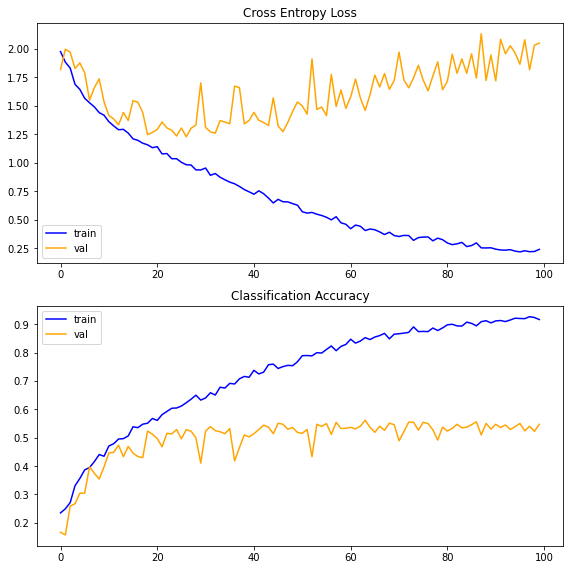

In [132]:
summarize_diagnostics(history1)

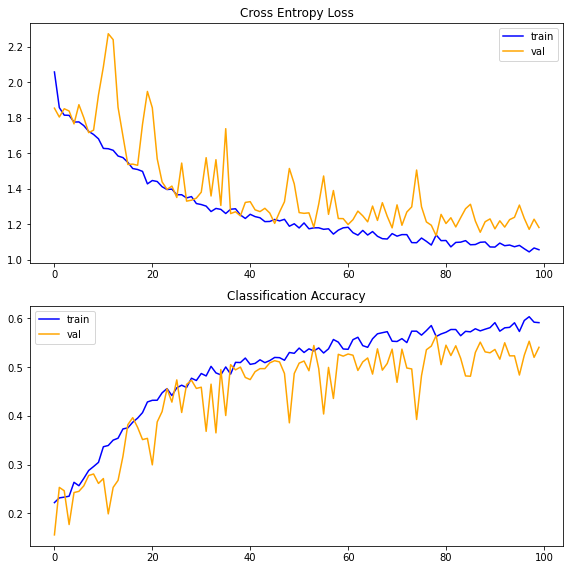

In [133]:
summarize_diagnostics(history1extra)

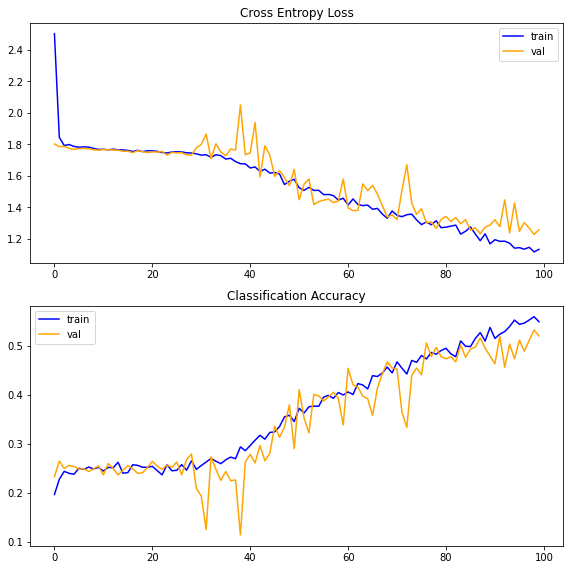

In [134]:
summarize_diagnostics(history2)

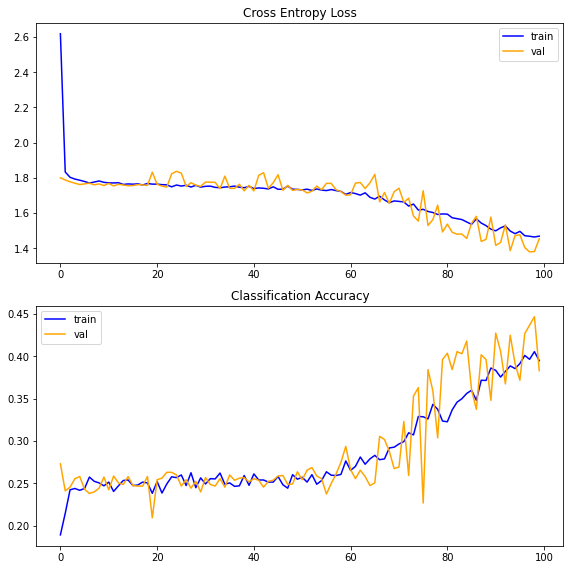

In [135]:
summarize_diagnostics(history2extra)

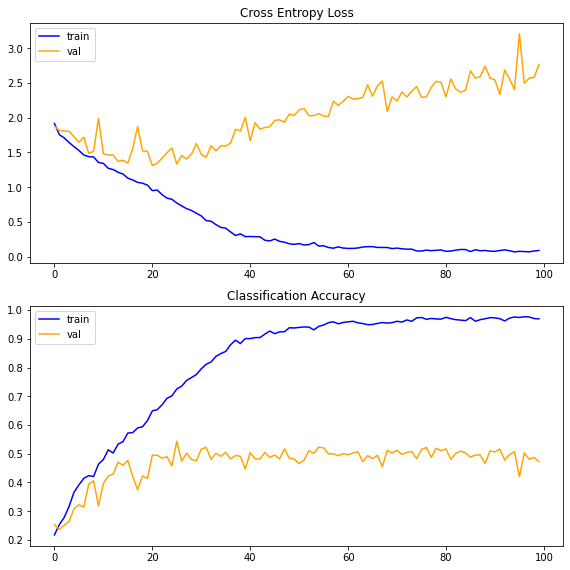

In [136]:
summarize_diagnostics(history3)

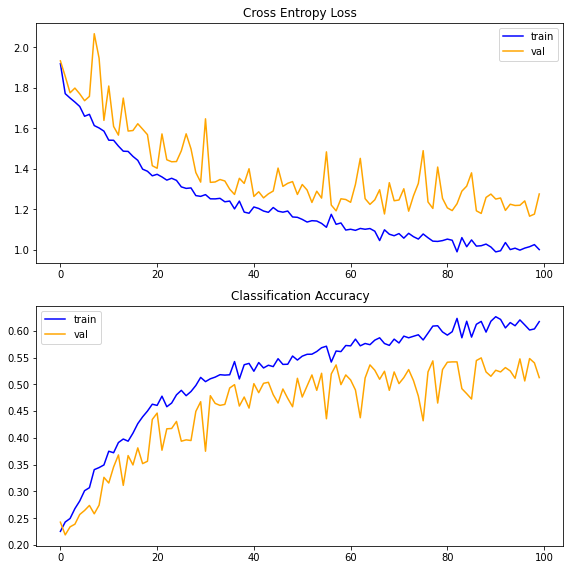

In [137]:
summarize_diagnostics(history3extra)